In [38]:
import io
import torch
import math
import numpy as np
import torchvision
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from contextlib import redirect_stdout
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.ops.boxes import box_convert
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

In [2]:
# implement functions for basic usage
def collate_fn(batch):
    """
    This function takes a batch of data and returns a tuple of zipped data.
    It is often used in PyTorch data loaders to collate multiple data samples into batches.
    """
    return tuple(zip(*batch))

In [3]:
# implement class for basic usage
class KeyPointDetection(datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        new_target = {}

        if self._transforms is not None:
            img = self._transforms(img)

        new_target["boxes"] = box_convert(torch.tensor([t['bbox'] for t in target]), in_fmt = 'xywh', out_fmt = 'xyxy')
        new_target["labels"] = torch.tensor([t['category_id'] for t in target], dtype = torch.int64)
        new_target["keypoints"] = torch.tensor([np.array(t['keypoints']).reshape(-1, 3).tolist() for t in target], dtype = torch.float32)

        return img, new_target

In [4]:
# set directories path
train_images_path = "../../../dataset/bottle_keypoint/train/image"
train_anns_path = "../../../dataset/bottle_keypoint/train/annotation/_annotations.coco.json"
val_images_path = "../../../dataset/bottle_keypoint/valid/image"
val_anns_path = "../../../dataset/bottle_keypoint/valid/annotation/_annotations.coco.json"

# train_images_path = "../../../dataset/test-haha/train/image"
# train_anns_path = "../../../dataset/test-haha/train/annotation/_annotations.coco.json"
# val_images_path = "../../../dataset/test-haha/valid/image"
# val_anns_path = "../../../dataset/test-haha/valid/annotation/_annotations.coco.json"

# set transform
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    v2.ToDtype(torch.float32, scale = True),
])

# temporarily redirect standard output to an in-memory text stream to suppress console output
with redirect_stdout(io.StringIO()):
    training_dataset = KeyPointDetection(
        img_folder = train_images_path, 
        ann_file = train_anns_path,
        transforms = transform
    )

    validation_dataset = KeyPointDetection(
        img_folder = val_images_path, 
        ann_file = val_anns_path,
        transforms = transform
    )

tensor([[[144.0000, 524.4440,   2.0000],
         [406.0000, 524.4440,   2.0000]]])


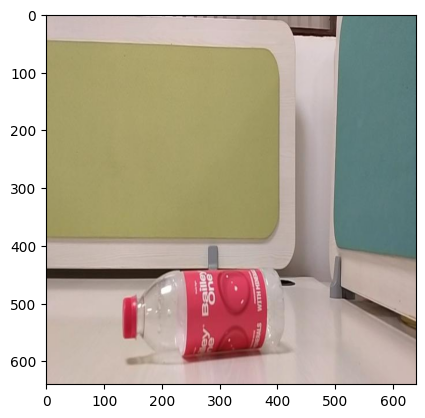

In [5]:
image, targets = training_dataset[0]
image_np = image.numpy().transpose((1, 2, 0))

fig, ax = plt.subplots(1)
ax.imshow(image_np)

print(targets["keypoints"])
# for keypoint in keypoints:
#     x, y, visibility = keypoint

#     if visibility > 0:
#         circle = patches.Circle((x, y), radius = 2, color = 'red')
#         ax.add_patch(circle)

plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 2

In [7]:
training_dataloader = DataLoader(
    training_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0,
    collate_fn = collate_fn
)

In [8]:
cat_ids = training_dataset.coco.getCatIds()
cat_info = training_dataset.coco.loadCats(cat_ids)
cat_names = [cat['name'] for cat in cat_info]

# supercategory is listed, can use it for background class
num_classes = len(training_dataset.coco.getCatIds())

max_keypoints = 0

for cat_id in cat_ids:
    cat_info = training_dataset.coco.loadCats(cat_id)[0]
    if 'keypoints' in cat_info:
        num_keypoints = len(cat_info['keypoints'])
        if num_keypoints > max_keypoints:
            max_keypoints = num_keypoints

print(f"category names: {cat_names}")
print(f'number of classes: {num_classes}')
print(f"maximum number of keypoints across all classes: {max_keypoints}")

category names: ['bottle', 'bottle']
number of classes: 2
maximum number of keypoints across all classes: 2


In [9]:
model = keypointrcnn_resnet50_fpn(weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)

# adjust model
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
in_features_keypoint = model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels
model.roi_heads.keypoint_predictor = torchvision.models.detection.keypoint_rcnn.KeypointRCNNPredictor(in_features_keypoint, max_keypoints)

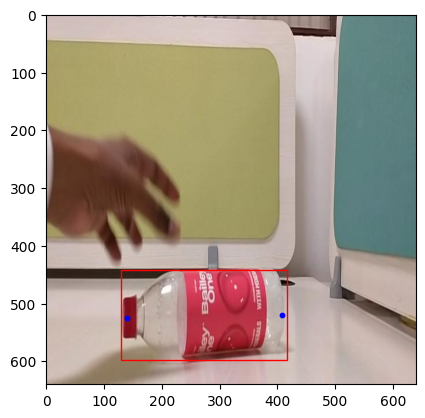

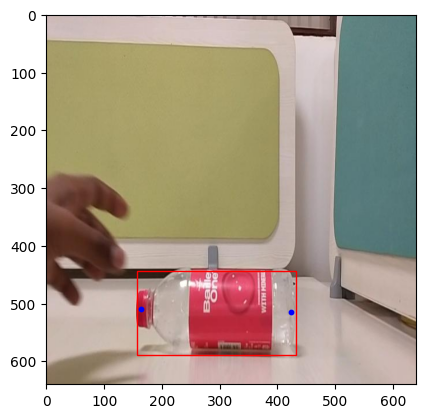

epoch 1, Loss: 5.9083
epoch 2, Loss: 3.7131
epoch 3, Loss: 3.3380
epoch 4, Loss: 2.8590
epoch 5, Loss: 2.7376


In [10]:
model = model.to(device)  # move model to the correct device

selected_keys = ['boxes', 'labels', 'keypoints']

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr = 0.001, momentum = 0.9, weight_decay = 0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()

    train_loss = 0.0

    for batch_idx, (images, targets) in enumerate(training_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items() if k in selected_keys} for t in targets]

        # zero the parameter gradients
        optimizer.zero_grad()

        # display on first batch and first epoch
        if batch_idx == 0 and epoch == 0:
            # display image for debugging
            for i, target in enumerate(targets):
                fig, ax = plt.subplots(1)
                ax.imshow(images[i].cpu().numpy().transpose((1, 2, 0)))

                # draw bounding boxes
                for box in target["boxes"]:
                    box = box.cpu().numpy()
                    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], 
                        linewidth = 1, edgecolor = 'r', facecolor = 'none')
                    ax.add_patch(rect)

                # draw keypoints
                for keypoint in target["keypoints"]:
                    for k in keypoint:
                        k = k.cpu().numpy()
                        plt.scatter(k[0], k[1], s = 10, c = 'blue', marker = 'o')

                plt.show()

        # forward + backward + optimize
        output = model(images, targets)
        losses = sum(loss for loss in output.values())
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f'epoch {epoch + 1}, Loss: {train_loss / len(training_dataloader):.4f}')

    # step the learning rate scheduler
    lr_scheduler.step()

In [57]:
validation_dataset[0][0].shape

model.eval()
prediction = model([validation_dataset[15][0].to(device)])
prediction

[{'boxes': tensor([[267.9261,  93.2022, 351.9286, 607.2306],
          [276.5190, 639.6624, 284.4741, 640.0000],
          [240.4847, 204.4405, 391.3112, 632.0599],
          [275.1699,  83.2281, 341.2557, 309.4394],
          [271.3091, 425.8992, 345.3483, 607.4245],
          [254.7795,  49.7360, 345.2945, 416.8746],
          [260.0293, 213.6303, 355.8043, 437.8185],
          [240.9596,  98.8455, 386.1420, 343.7412],
          [273.6146, 144.1693, 331.3602, 428.7608],
          [234.6027, 243.8527, 407.6195, 459.1039],
          [254.5781, 154.6211, 346.3716, 327.2284],
          [250.8572,  17.6667, 471.2486, 637.1512],
          [286.6199,  78.7469, 339.1750, 157.1660],
          [639.2032, 116.1477, 640.0000, 130.2993],
          [197.8206,  53.9417, 365.1638, 614.8662],
          [639.1830, 122.2946, 640.0000, 135.3667]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor

In [60]:
def calculate_angle(x1, y1, x2, y2):
    # calculate the differences in coordinates
    delta_x = x2 - x1
    delta_y = y2 - y1

    # calculate the angle using arctan2 and convert it to degrees
    angle_rad = math.atan2(delta_y, delta_x)
    angle_deg = math.degrees(angle_rad)

    # ensure the angle is between 0 and 360 degrees
    mapped_angle = angle_deg % 360
    if mapped_angle < 0:
        mapped_angle += 360  # ensure angle is positive

    return mapped_angle

270.46176454981634
correct orientation


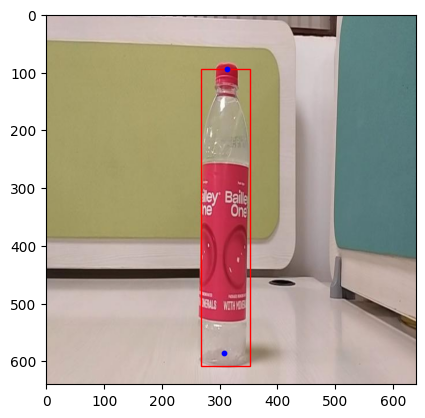

In [62]:
image = validation_dataset[15][0].cpu().numpy().transpose((1, 2, 0))
boxes = prediction[0]['boxes'].cpu().detach().numpy()
keypoints = prediction[0]['keypoints'].cpu().detach().numpy()
scores = prediction[0]['scores'].cpu().detach().numpy()

# find the index of the bounding box with the highest score
max_score_index = scores.argmax()

# select the bounding box and keypoints with the highest score
max_score_box = boxes[max_score_index]
max_score_keypoints = keypoints[max_score_index]

fig, ax = plt.subplots(1)
ax.imshow(image)

top_x, top_y = max_score_keypoints[0][0], max_score_keypoints[0][1]
bottom_x, bottom_y = max_score_keypoints[1][0], max_score_keypoints[1][1]

angle = calculate_angle(bottom_x, bottom_y, top_x, top_y)
print(angle)

if 0 <= angle <= 85 or 95 <= angle <= 185:
    print("wrong orientation")
elif 85 <= angle <= 95 or 265 <= angle <= 275:
    print("correct orientation")

# draw the bounding box with the highest score
rect = patches.Rectangle((max_score_box[0], max_score_box[1]), max_score_box[2] - max_score_box[0], max_score_box[3] - max_score_box[1], 
    linewidth = 1, edgecolor = 'r', facecolor = 'none')
ax.add_patch(rect)

# draw the keypoints for the bounding box with the highest score
for k in max_score_keypoints:
    plt.scatter(k[0], k[1], s = 10, c = 'blue', marker = 'o')

plt.show()